[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Arif-PhyChem/trace_conservation/blob/main/physics_agnostic.ipynb)

In [1]:
import sys
import os

! git clone https://github.com/Arif-PhyChem/MLQD.git

Cloning into 'MLQD'...
remote: Enumerating objects: 1044, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 1044 (delta 162), reused 224 (delta 107), pack-reused 724 (from 1)
Receiving objects: 100% (1044/1044), 34.99 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (454/454), done.


In [2]:
# install the required packages

! pip install tensorflow --upgrade
! pip install sklearn
! pip install hyperopt

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
# Add MLQD's path to system path

mlqd_dir='MLQD/dev_ver'
sys.path.append(mlqd_dir)

from evolution import quant_dyn



In [4]:
# get training and test data files from github
! git clone https://github.com/Arif-PhyChem/trace_conservation.git

Cloning into 'trace_conservation'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 178 (delta 33), reused 0 (delta 0), pack-reused 110 (from 1)
Receiving objects: 100% (178/178), 202.28 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (38/38), done.


# Physics-agnostic NN for spin boson (SB) model

In the case of physics-agnostic neural networks, we train separate Convolutional Neural Networks (CNNs) for each element of the diagonal Reduced Density Matrix (RDM). We use a loss function to measure the difference between the NN-predicted values $\bar{\tilde{\rho}}_{{\rm S},nn}$ and their reference counterparts $\tilde{\rho}_{{\rm S},nn}$:

\begin{equation}
    \mathcal{L}_{nn} =  \sum_{m=1}^M \left(\bar{\tilde{\rho}}_{{\rm S},nn,m} - \tilde{\rho}_{{\rm S},nn,m} \right)^2,
\end{equation}

where $M$ is the number of training points and $m$ is the index of a training point.

Since these models are not informed about the dynamics of all states, they do not inherently understand trace conservation. To facilitate training in this process, we provide pre-prepared training files named 'x.npy' and 'y.npy'. Alternatively, you can create your own training files using the MLQD tool available on GitHub at [MLQD GitHub](https://github.com/Arif-PhyChem/MLQD), along with data from the QD3SET-1 database, accessible via the DOI link [QD3SET-1 DOI](https://doi.org/10.25452/figshare.plus.c.6389553).

## Spin boson (SB) model

Here we will train individual CNN models for each state. For quick run, we are setting training epochs 'TrEpochs' to 10, you should set it to a higher number for better training.




In [5]:
# sb training files (x and y) for physics agnostic NN provided at Zenodo
! wget --content-disposition https://zenodo.org/records/13446756/files/training_data.zip?download=1

--2024-09-03 06:52:06--  https://zenodo.org/records/13446756/files/training_data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380879719 (363M) [application/octet-stream]
Saving to: ‘training_data.zip’

training_data.zip   100%[===================>] 363.23M  28.5MB/s    in 14s     

2024-09-03 06:52:20 (26.4 MB/s) - ‘training_data.zip’ saved [380879719/380879719]



In [6]:
# Unzip it
! unzip training_data

Archive:  training_data.zip
   creating: training_data/
   creating: training_data/fmo/
   creating: training_data/fmo/hc_pinn/
  inflating: training_data/fmo/hc_pinn/x.npy  
  inflating: training_data/fmo/hc_pinn/y01.npy  
   creating: training_data/fmo/physics_agnostic/
   creating: training_data/fmo/physics_agnostic/site_1/
  inflating: training_data/fmo/physics_agnostic/site_1/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_1/y.npy  
   creating: training_data/fmo/physics_agnostic/site_2/
  inflating: training_data/fmo/physics_agnostic/site_2/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_2/y.npy  
   creating: training_data/fmo/physics_agnostic/site_3/
  inflating: training_data/fmo/physics_agnostic/site_3/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_3/y.npy  
   creating: training_data/fmo/physics_agnostic/site_4/
  inflating: training_data/fmo/physics_agnostic/site_4/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_4/y.npy  

In [69]:
# input for MLQD package, more details are given at https://github.com/Arif-PhyChem/MLQD
for i in range(1, 3):

  param={
    'n_states': 2,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/sb/physics_agnostic/state_' + str(i) + '/x',  # str: (Optional) The prepared X file
      'YfileIn': 'training_data/sb/physics_agnostic/state_' + str(i) + '/y',  # str: (Optional) The prepared Y file
      'hyperParam': 'False',  # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'SB'
    }
  quant_dyn(**param)
  # Define the directory containing the models
  directory = 'trained_models'

  # Iterate through all files in the directory
  for filename in os.listdir(directory):
    if filename.startswith("SB") and filename.endswith('.keras'):  # Check if the file is a model file
      # Construct the new filename with 'site' prefixed
      new_filename = 'state_' + str(i) + '_' + filename
      # Construct full file paths
      old_file = os.path.join(directory, filename)
      new_file = os.path.join(directory, new_filename)
      # Rename the file
      os.rename(old_file, new_file)
      print(f'Renamed: {old_file} to {new_file}')


MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_loss improved from inf to 0.00323, saving model to trained_models/SB_cnn_model-01-tloss-3.265e-02-vloss-3.228e-03.keras
90/90 - 4s - 48ms/step - loss: 0.0327 - val_loss: 0.0032
Epoch 2/10

Epoch 2: val_loss improved from 0.00323 to 0.00062, saving model to trained_models/SB_cnn_model-02-tloss-1.684e-03-vloss-6.153e-04.keras
90/90 - 2s - 27ms/step - loss: 0.0017 - val_loss: 6.1528e-04
Epoch 3/10

Epoch 3: val_loss improved from 0.00062 to 0.00027, saving model to trained_models/SB_cnn_model-03-tloss-4.450e-04-vloss-2.748e-04.keras
90/90 - 3s - 28ms/step - loss: 4.4500e-04 - val_loss: 2.7476e-04
Epoch 4/10

Epoch 4: val_loss improved from 0.00027 to 0.00020, saving model to trained_models/SB_cnn_model-04-tloss-2.906e-04-vloss-1.997e-04.keras
90/90 - 4s - 43ms/step - loss: 2.9064e-04 - val_loss: 1.9972e-04
Epoch 5/10

Epoch 5: val_loss improved from 0.00020 to 0.00014, saving model to trained_models/SB_cnn_model-05-tloss-2.055e-04-vloss-1.403e-04.keras
90/90 - 3s - 38ms/step

In [77]:
# Grab trained SB models for all states with max epoch number

from datetime import datetime

# Directory containing the models
model_dir = "trained_models"

# List all models in the directory
models_1 = [f for f in os.listdir(model_dir) if f.startswith("state_1") and f.endswith(".keras")]
models_2 = [f for f in os.listdir(model_dir) if f.startswith("state_2") and f.endswith(".keras")]

state_1_models = {}
state_2_models = {}

for model in models_1:
  epoch_number = int(model.split("-")[1])
  state_1_models[epoch_number] = model
for model in models_2:
  epoch_number = int(model.split("-")[1])

  state_2_models[epoch_number] = model

# Find the maximum epoch number
max_epoch = max(state_1_models.keys())

# Get the model with the largest epoch number
max_epoch_model_4_state_1 = state_1_models[max_epoch]

print("Model with the largest epoch for state 1:", max_epoch_model_4_state_1)

max_epoch = max(state_2_models.keys())

# Get the model with the largest epoch number
max_epoch_model_4_state_2 = state_2_models[max_epoch]

print("Model with the largest epoch for state 2:", max_epoch_model_4_state_2)

Model with the largest epoch for state 1: state_1_SB_cnn_model-10-tloss-8.806e-05-vloss-6.437e-05.keras
Model with the largest epoch for state 2: state_2_SB_cnn_model-09-tloss-6.440e-05-vloss-5.783e-05.keras


## Trace for a test trajectory

In [78]:
# test tarjectory
! ls trace_conservation/test_data/sb/

2_epsilon-0.0_Delta-1.0_lambda-0.6_gamma-9.0_beta-1.0.npy


In [80]:
import keras
xx = np.load('trace_conservation/test_data/sb/2_epsilon-0.0_Delta-1.0_lambda-0.6_gamma-9.0_beta-1.0.npy')

trained_model_4_state_1 = keras.models.load_model('trained_models/'+max_epoch_model_4_state_1, compile=False)
trained_model_4_state_2 = keras.models.load_model('trained_models/'+max_epoch_model_4_state_2, compile=False)

#Show the model architecture
Xin = xx[0:41,1]

models = [trained_model_4_state_1, trained_model_4_state_2]

gamma = 9.0
lamb = 0.6
beta = 1.0
nsp = 3 # number of simulation parameters

prior = 0
n_states = 2
time_step = 0.05
time = 20
ostl_steps = 20
tm = Xin.shape[0]
time_range=0
tt = time_range


x = np.zeros((1, nsp+tm), dtype=float)

x[0, 0] = gamma/10
x[0, 1] = lamb/1.0
x[0, 2] = beta/1.0


for i in range(0, tm + int(time/time_step)-1):
    tt += time_step
    time_range = np.append(time_range, tt)

y = np.zeros((len(time_range), n_states), dtype=complex)

state = 0
for dataCol in (1, 4):

    Xin = xx[0:41,dataCol]

    x[0, nsp:] = Xin.real

    print('ml_dyn.RCDYN: Running recursive dynamics with CNN model......')

    y[0:tm, state] = Xin;
    tt = tm
    for i in range(tm, len(time_range), ostl_steps):
        x_pred = x
        x_pred = x_pred.reshape(1, x.shape[1],1) # reshape the input
        yhat = models[state].predict(x_pred, verbose=0) - prior
        x = np.append(x, yhat)
        x1 = x.reshape(1, x.shape[0])
        x2 = x1[0, nsp+ostl_steps:]
        x = x1[0, 0:nsp]
        x = np.append(x, x2)
        x = x.reshape(1, -1)
        ytmp = yhat[0]
        for step in range(0, yhat.shape[-1]):
            y[tt, state] = ytmp[step]

            tt += 1
    state += 1
np.save('physics_agnostic_sb_traj', np.c_['-1',time_range[:], y[:]])
print('Trajectory is saved as physics_agnostic_sb_traj.npy')

ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
Trajectory is saved as physics_agnostic_sb_traj.npy


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'time$(\\Delta)$')

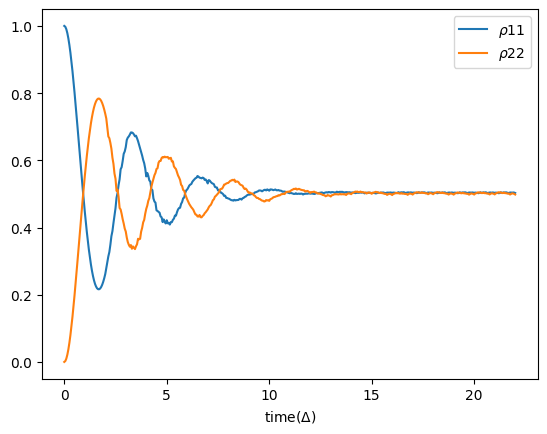

In [81]:
# Plot elements of rho
import matplotlib.pyplot as plt
x = np.load('physics_agnostic_sb_traj.npy')

plt.plot(x[:,0], x[:, 1], label=r'$\rho$11') # Population of state_1
plt.plot(x[:,0], x[:, 2], label=r'$\rho$22')  # Population of state_2
plt.legend()
plt.xlabel(r'time$(\Delta)$')

Text(0, 0.5, 'Trace')

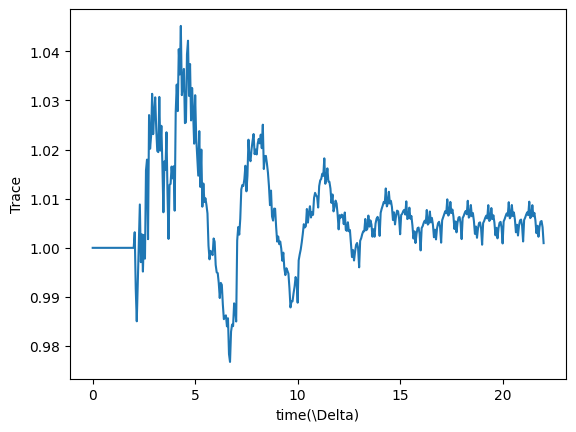

In [82]:
# Plot trace vs time
x = np.load('physics_agnostic_sb_traj.npy')
trace = np.real(x[:,1] + x[:,2])

plt.plot(x[:,0], trace)
plt.xlabel('time(\Delta)')
plt.ylabel('Trace')

## As these models are not exposed to the dynamics of all states, they lack knowledge of trace conservation. Therefore, they fail to conserve trace.

# Let's do it for FMO complex

Here for quick run, we train CNN models only for 10 epochs "TrEpochs" = 10, however for better training, you should train it for more epochs

In [83]:
# input for MLQD package, more details are given at https://github.com/Arif-PhyChem/MLQD
for i in range(1, 8):
  param={
    'n_states': 7,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/fmo/physics_agnostic/site_'+ str(i) + '/x',           # str: (Optional) The prepared X file
      'YfileIn': 'training_data/fmo/physics_agnostic/site_' + str(i) + '/y',           # str: (Optional) The prepared Y file
      'hyperParam': 'False', # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'FMO'
      }
  quant_dyn(**param)
  import os

  # Define the directory containing the models
  directory = 'trained_models'

  # Iterate through all files in the directory
  for filename in os.listdir(directory):
    if filename.startswith("FMO") and filename.endswith('.keras'):  # Check if the file is a model file
      # Construct the new filename with 'site' prefixed
      new_filename = 'site_' + str(i) + '_' + filename
      # Construct full file paths
      old_file = os.path.join(directory, filename)
      new_file = os.path.join(directory, new_filename)
      # Rename the file
      os.rename(old_file, new_file)
      print(f'Renamed: {old_file} to {new_file}')


MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_loss improved from inf to 0.00018, saving model to trained_models/FMO_cnn_model-01-tloss-4.718e-03-vloss-1.800e-04.keras
105/105 - 7s - 70ms/step - loss: 0.0047 - val_loss: 1.8005e-04
Epoch 2/10

Epoch 2: val_loss improved from 0.00018 to 0.00009, saving model to trained_models/FMO_cnn_model-02-tloss-1.217e-04-vloss-8.840e-05.keras
105/105 - 8s - 79ms/step - loss: 1.2169e-04 - val_loss: 8.8404e-05
Epoch 3/10

Epoch 3: val_loss improved from 0.00009 to 0.00005, saving model to trained_models/FMO_cnn_model-03-tloss-6.889e-05-vloss-4.954e-05.keras
105/105 - 4s - 40ms/step - loss: 6.8893e-05 - val_loss: 4.9537e-05
Epoch 4/10

Epoch 4: val_loss did not improve from 0.00005
105/105 - 3s - 27ms/step - loss: 5.0462e-05 - val_loss: 5.2071e-05
Epoch 5/10

Epoch 5: val_loss did not improve from 0.00005
105/105 - 3s - 27ms/step - loss: 3.6244e-05 - val_loss: 8.0818e-05
Epoch 6/10

Epoch 6: val_loss improved from 0.00005 to 0.00002, saving model to trained_models/FMO_cnn_model-06-tlos

In [93]:
# Grab trained FMO models for all sites with max epoch number

from datetime import datetime

# Directory containing the models
model_dir = "trained_models"

# List all models in the directory
models_1 = [f for f in os.listdir(model_dir) if f.startswith("site_1") and f.endswith(".keras")]
models_2 = [f for f in os.listdir(model_dir) if f.startswith("site_2") and f.endswith(".keras")]
models_3 = [f for f in os.listdir(model_dir) if f.startswith("site_3") and f.endswith(".keras")]
models_4 = [f for f in os.listdir(model_dir) if f.startswith("site_4") and f.endswith(".keras")]
models_5 = [f for f in os.listdir(model_dir) if f.startswith("site_5") and f.endswith(".keras")]
models_6 = [f for f in os.listdir(model_dir) if f.startswith("site_6") and f.endswith(".keras")]
models_7 = [f for f in os.listdir(model_dir) if f.startswith("site_7") and f.endswith(".keras")]

# Separate models into different sites
site_1_models = {}
site_2_models = {}
site_3_models = {}
site_4_models = {}
site_5_models = {}
site_6_models = {}
site_7_models = {}

sites_models = [models_1, models_2, models_3, models_4, models_5, models_6, models_7]
k = 1
for site_models in sites_models:
  for model in site_models:
    if k == 1:
      epoch_number = int(model.split("-")[1])
      site_1_models[epoch_number] = model
    if k == 2:
      epoch_number = int(model.split("-")[1])
      site_2_models[epoch_number] = model
    if k == 3:
      epoch_number = int(model.split("-")[1])
      site_3_models[epoch_number] = model
    if k == 4:
      epoch_number = int(model.split("-")[1])
      site_4_models[epoch_number] = model
    if k == 5:
      epoch_number = int(model.split("-")[1])
      site_5_models[epoch_number] = model
    if k == 6:
      epoch_number = int(model.split("-")[1])
      site_6_models[epoch_number] = model
    if k == 7:
      epoch_number = int(model.split("-")[1])
      site_7_models[epoch_number] = model
  k += 1
print(site_1_models)
# Find the maximum epoch number
models_with_max_epoch = {}
for i in range(1, 8):
  models = eval(f"site_{i}_models")
  max_epoch = max(models.keys())

  # Get the model with the largest epoch number
  max_epoch_model = models[max_epoch]

  models_with_max_epoch[i] = max_epoch_model
  print("Model with the largest epoch for state " + str(i) + ":", max_epoch_model)

{9: 'site_1_FMO_cnn_model-09-tloss-2.935e-05-vloss-1.877e-05.keras', 2: 'site_1_FMO_cnn_model-02-tloss-1.217e-04-vloss-8.840e-05.keras', 10: 'site_1_FMO_cnn_model-10-tloss-1.436e-05-vloss-1.641e-05.keras', 7: 'site_1_FMO_cnn_model-07-tloss-2.360e-05-vloss-1.885e-05.keras', 1: 'site_1_FMO_cnn_model-01-tloss-4.718e-03-vloss-1.800e-04.keras', 6: 'site_1_FMO_cnn_model-06-tloss-3.482e-05-vloss-2.237e-05.keras', 3: 'site_1_FMO_cnn_model-03-tloss-6.889e-05-vloss-4.954e-05.keras'}
Model with the largest epoch for state 1: site_1_FMO_cnn_model-10-tloss-1.436e-05-vloss-1.641e-05.keras
Model with the largest epoch for state 2: site_2_FMO_cnn_model-10-tloss-6.190e-06-vloss-6.366e-06.keras
Model with the largest epoch for state 3: site_3_FMO_cnn_model-10-tloss-6.485e-06-vloss-3.340e-06.keras
Model with the largest epoch for state 4: site_4_FMO_cnn_model-07-tloss-2.012e-06-vloss-1.186e-06.keras
Model with the largest epoch for state 5: site_5_FMO_cnn_model-10-tloss-1.091e-06-vloss-6.260e-07.keras
Mo

In [97]:
import keras
test_traj = '7_initial-1_gamma-400.0_lambda-40.0_temp-90.0.npy'
xx = np.load('trace_conservation/test_data/fmo/' + test_traj)


model_1 = keras.models.load_model('trained_models/'+models_with_max_epoch[1], compile=False)
model_2 = keras.models.load_model('trained_models/'+models_with_max_epoch[2], compile=False)
model_3 = keras.models.load_model('trained_models/'+models_with_max_epoch[3], compile=False)
model_4 = keras.models.load_model('trained_models/'+models_with_max_epoch[4], compile=False)
model_5 = keras.models.load_model('trained_models/'+models_with_max_epoch[5], compile=False)
model_6 = keras.models.load_model('trained_models/'+models_with_max_epoch[6], compile=False)
model_7 = keras.models.load_model('trained_models/'+models_with_max_epoch[7], compile=False)

#Show the model architecture
Xin = xx[0:41,1]

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]

gamma = 400.0
lamb = 40.0
beta = 90.0
nsp = 3 # number of simulation parameters

prior = 0
n_states = 7
time_step = 0.005
ostl_steps = 20
time = 2
tm = Xin.shape[0]
time_range=0
tt = time_range


x = np.zeros((1, nsp+tm), dtype=float)

x[0, 0] = gamma/500
x[0, 1] = lamb/530.0
x[0, 2] = beta/510.0

for i in range(0, tm + int(time/time_step)-1):
    tt += time_step
    time_range = np.append(time_range, tt)

print(len(time_range))


y = np.zeros((len(time_range), n_states), dtype=complex)

state = 0
for dataCol in (1, 9, 17, 25, 33, 41, 49):

    Xin = xx[0:41,dataCol]

    x[0, nsp:] = Xin.real

    print('ml_dyn.RCDYN: Running recursive dynamics with CNN model......')

    y[0:tm, state] = Xin;
    tt = tm
    for i in range(tm, len(time_range), ostl_steps):
        x_pred = x
        x_pred = x_pred.reshape(1, x.shape[1],1) # reshape the input
        yhat = models[state].predict(x_pred, verbose=0) - prior
        x = np.append(x, yhat)
        x1 = x.reshape(1, x.shape[0])
        x2 = x1[0, nsp+ostl_steps:]
        x = x1[0, 0:nsp]
        x = np.append(x, x2)
        x = x.reshape(1, -1)
        ytmp = yhat[0]
        for step in range(0, ostl_steps):
            y[tt, state] = ytmp[step]

            tt += 1
    state += 1

np.save('physics_agnostic_fmo_traj', np.c_['-1',time_range[:], y[:]])
print('Trajectory is saved as physics_agnostic_fmo_traj.npy')

441
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Running recursive dynamics with CNN model......
Trajectory is saved as physics_agnostic_fmo_traj.npy


## Similar to SB case, these models are not exposed to the dynamics of all states, so they lack knowledge of trace conservation. Therefore, they fail to conserve trace.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'time(ps)')

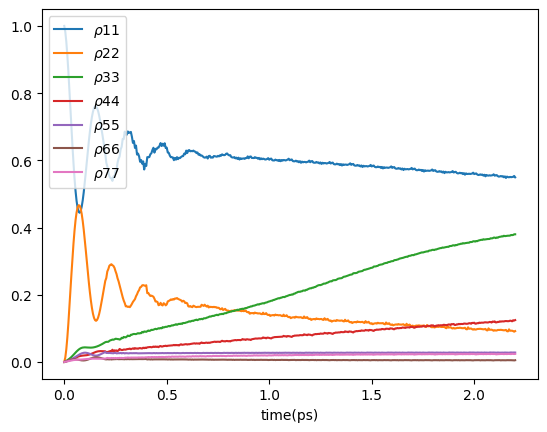

In [100]:
# Plotting diagonal terms of rho
x = np.load('physics_agnostic_fmo_traj.npy')

label=1
for i in range(1, 8):
  plt.plot(x[:,0], x[:, i], label=r'$\rho$'+str(label)+str(label))
  label += 1
plt.legend()
plt.xlabel('time(ps)')

Text(0, 0.5, 'Trace')

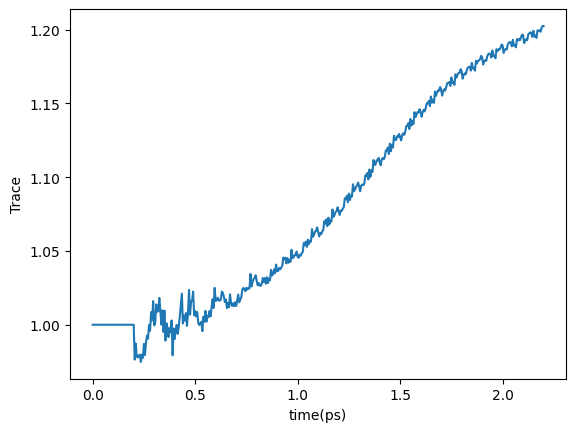

In [101]:
# Plot trace vs time

x = np.load('physics_agnostic_fmo_traj.npy')
trace = 0.0
for i in range(1, 8):
  trace += np.real(x[:,i])

plt.plot(x[:,0], trace)
plt.xlabel('time(ps)')
plt.ylabel('Trace')